In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data, prep_fa_dataset, prep_first_tract_data
from afqinsight.nn.utils import prep_fa_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import Conv1DAutoencoder
from afqinsight.nn.utils import reconstruction_loss




/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [3]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [4]:
def prep_all_tracts_data(dataset, batch_size=32):
    # First get your original dataset splits
    torch_dataset_fa, train_loader_fa, test_loader_fa, val_loader_fa = prep_fa_dataset(dataset,batch_size=64)

    
    class AllTractsDataset(torch.utils.data.Dataset):
        def __init__(self, original_dataset):
            self.original_dataset = original_dataset
            # Calculate total length (num_samples * num_tracts)
            self.sample_count = len(original_dataset)
            self.tract_count = original_dataset[0][0].shape[0]  # Assuming first dimension is tracts
            
        def __len__(self):
            return self.sample_count * self.tract_count
            
        def __getitem__(self, idx):
            # Convert flat index to sample_idx and tract_idx
            sample_idx = idx // self.tract_count
            tract_idx = idx % self.tract_count
            
            # Get original sample
            x, y = self.original_dataset[sample_idx]
            
            # Extract specific tract
            tract_data = x[tract_idx:tract_idx+1, :].clone()  # Keep dimension as [1, 50]
            # Alternative: tract_data = x[tract_idx, :].clone()  # Shape will be [50]
            
            return tract_data, y
    
    # Create datasets with all tracts
    all_tracts_train_dataset = AllTractsDataset(train_loader_fa.dataset)
    all_tracts_test_dataset = AllTractsDataset(test_loader_fa.dataset)
    all_tracts_val_dataset = AllTractsDataset(val_loader_fa.dataset)
    
    # Create data loaders
    all_tracts_train_loader = torch.utils.data.DataLoader(
        all_tracts_train_dataset, batch_size=batch_size, shuffle=True
    )
    all_tracts_test_loader = torch.utils.data.DataLoader(
        all_tracts_test_dataset, batch_size=batch_size, shuffle=False
    )
    all_tracts_val_loader = torch.utils.data.DataLoader(
        all_tracts_val_dataset, batch_size=batch_size, shuffle=False
    )
    
    return (
        torch_dataset,
        all_tracts_train_loader,
        all_tracts_test_loader,
        all_tracts_val_loader,
    )

In [5]:
torch_dataset, all_tracts_train_loader, all_tracts_test_loader, all_tracts_val_loader = prep_all_tracts_data(dataset,batch_size=64)

In [6]:
print("First Tract train Data", len(all_tracts_train_loader.dataset))
print("First Tract test Data", len(all_tracts_test_loader.dataset))
print("First Tract val Data", len(all_tracts_val_loader.dataset))
print("first tract training data shape", all_tracts_train_loader.dataset[0][0].shape)
print("torch dataset shape", torch_dataset[0][0].shape)

print("First Tract train Data", len(train_loader.dataset))
print(train_loader.dataset[0][0].shape)

First Tract train Data 57312
First Tract test Data 17952
First Tract val Data 14352
first tract training data shape torch.Size([1, 50])
torch dataset shape torch.Size([48, 100])
First Tract train Data 1194
torch.Size([48, 100])


In [7]:
class Conv1DEncoder_one_tract_fa(nn.Module):
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2)  
        self.conv2 = nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=2)  
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv1d(64, latent_dims, kernel_size=5, stride=2, padding=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)

        self.relu = nn.ReLU()


    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = F.relu(self.conv1(x)) 
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)   
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.conv4(x)
        return x
    
class Conv1DDecoder_one_tract_fa(nn.Module):
    def __init__(self, latent_dims=20):
        super().__init__()

        self.deconv1 = nn.ConvTranspose1d(latent_dims, 64, kernel_size=5, stride=2, padding=2, output_padding=0)  
        self.deconv2 = nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=0)  
        self.deconv3 = nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=2, output_padding=1)
        self.deconv4 = nn.ConvTranspose1d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1)

        self.relu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.deconv1(x)) 
        x = F.relu(self.deconv2(x))   
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        x = self.sigmoid(x)
        return x
        # return x.view(batch_size, -1)

class Conv1DAutoencoder_one_tract_fa(nn.Module): 
    def __init__(self, latent_dims=20, dropout=0.0):
        super().__init__()
        self.encoder = Conv1DEncoder_one_tract_fa(latent_dims, dropout=dropout)
        self.decoder = Conv1DDecoder_one_tract_fa(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        x_prime = self.decoder(z)
        return x_prime

In [8]:
def train_autoencoder_widescope(model, train_data, val_data, epochs=500, lr=0.001):    
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    best_val_loss = float('inf')  # Track the best (lowest) validation RMSE
    best_model_state = None  # Save the best model state
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0
        running_rmse = 0
        items = 0
        
        for x, _ in train_data:
            batch_size = x.size(0)
            tract_data = x[:, 0:1, :].to(device)  # Shape: (batch_size, 100)
            
            opt.zero_grad()
            x_hat = model(tract_data)
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
            
            loss.backward()
            opt.step()
            
            items += tract_data.size(0)
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum
            
        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        train_rmse_per_epoch.append(avg_train_rmse)
        
        # Validation
        model.eval()
        val_rmse = 0
        val_items = 0
        
        with torch.no_grad():
            for x, _ in val_data:
                tract_data = x[:, 0:1, :].to(device)
                x_hat = model(tract_data)
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
                val_items += tract_data.size(0)
                val_rmse += batch_val_rmse.item() * tract_data.size(0)
                
        avg_val_rmse = val_rmse / val_items
        val_rmse_per_epoch.append(avg_val_rmse)
        
        # Check and save the best model state if current validation loss is lower
        if avg_val_rmse < best_val_loss:
            best_val_loss = avg_val_rmse
            best_model_state = model.state_dict().copy()  # Make a copy to ensure it's preserved
            
        print(f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}")
    
    # Load the best model state back into the model
    model.load_state_dict(best_model_state)
    
    return {
        "train_rmse_per_epoch": train_rmse_per_epoch,
        "val_rmse_per_epoch": val_rmse_per_epoch,
        "best_val_loss": best_val_loss
    }




In [9]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
models = {}
results = {}

for latent_dim in latent_dims:
    print(f"Training Autoencoder with Latent Dimension: {latent_dim}")
    
    # Initialize a new autoencoder for each latent dimension
    test_model = Conv1DAutoencoder_one_tract_fa(latent_dims=latent_dim).to(device)
    
    # Train the model
    training_results = train_autoencoder_widescope(test_model, all_tracts_train_loader, all_tracts_val_loader, 500, 0.001)
    
    # Store both the model and results
    models[latent_dim] = test_model
    results[latent_dim] = training_results
    
    print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_loss']:.4f}")



Training Autoencoder with Latent Dimension: 2
Epoch 1, Train RMSE: 0.0242, Val RMSE: 0.0119
Epoch 2, Train RMSE: 0.0126, Val RMSE: 0.0111
Epoch 3, Train RMSE: 0.0119, Val RMSE: 0.0108
Epoch 4, Train RMSE: 0.0110, Val RMSE: 0.0101
Epoch 5, Train RMSE: 0.0106, Val RMSE: 0.0096
Epoch 6, Train RMSE: 0.0104, Val RMSE: 0.0094
Epoch 7, Train RMSE: 0.0102, Val RMSE: 0.0096
Epoch 8, Train RMSE: 0.0101, Val RMSE: 0.0092
Epoch 9, Train RMSE: 0.0099, Val RMSE: 0.0096
Epoch 10, Train RMSE: 0.0099, Val RMSE: 0.0090
Epoch 11, Train RMSE: 0.0098, Val RMSE: 0.0091
Epoch 12, Train RMSE: 0.0098, Val RMSE: 0.0091
Epoch 13, Train RMSE: 0.0097, Val RMSE: 0.0091
Epoch 14, Train RMSE: 0.0097, Val RMSE: 0.0089
Epoch 15, Train RMSE: 0.0096, Val RMSE: 0.0088
Epoch 16, Train RMSE: 0.0096, Val RMSE: 0.0107
Epoch 17, Train RMSE: 0.0096, Val RMSE: 0.0092
Epoch 18, Train RMSE: 0.0095, Val RMSE: 0.0089
Epoch 19, Train RMSE: 0.0095, Val RMSE: 0.0089
Epoch 20, Train RMSE: 0.0095, Val RMSE: 0.0089
Epoch 21, Train RMSE: 0

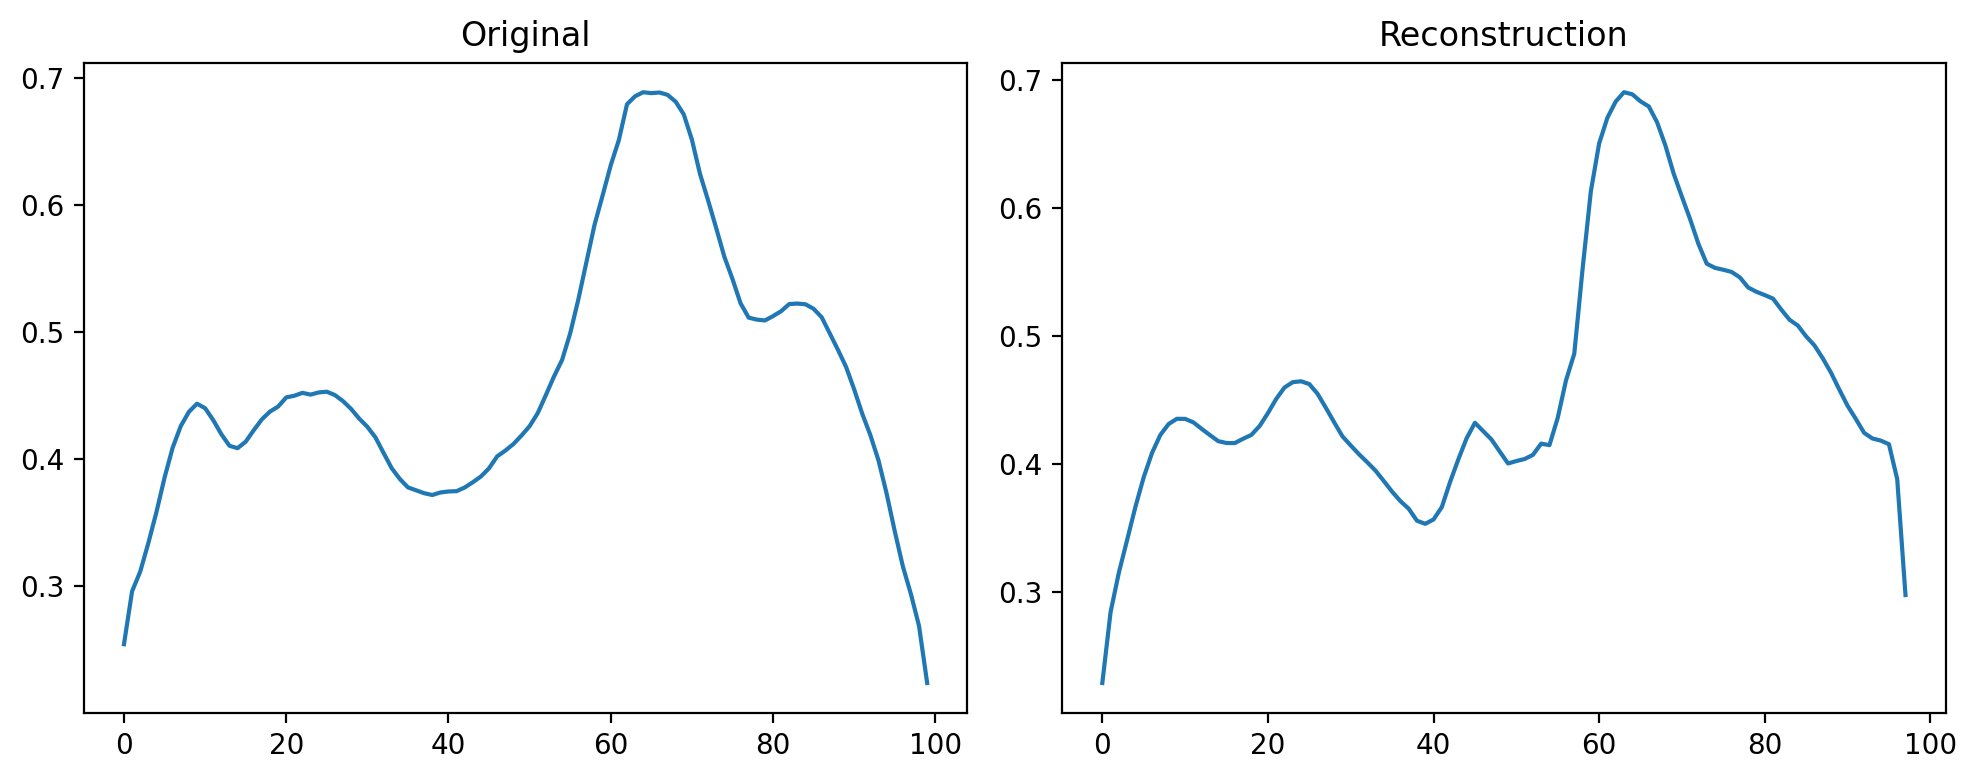

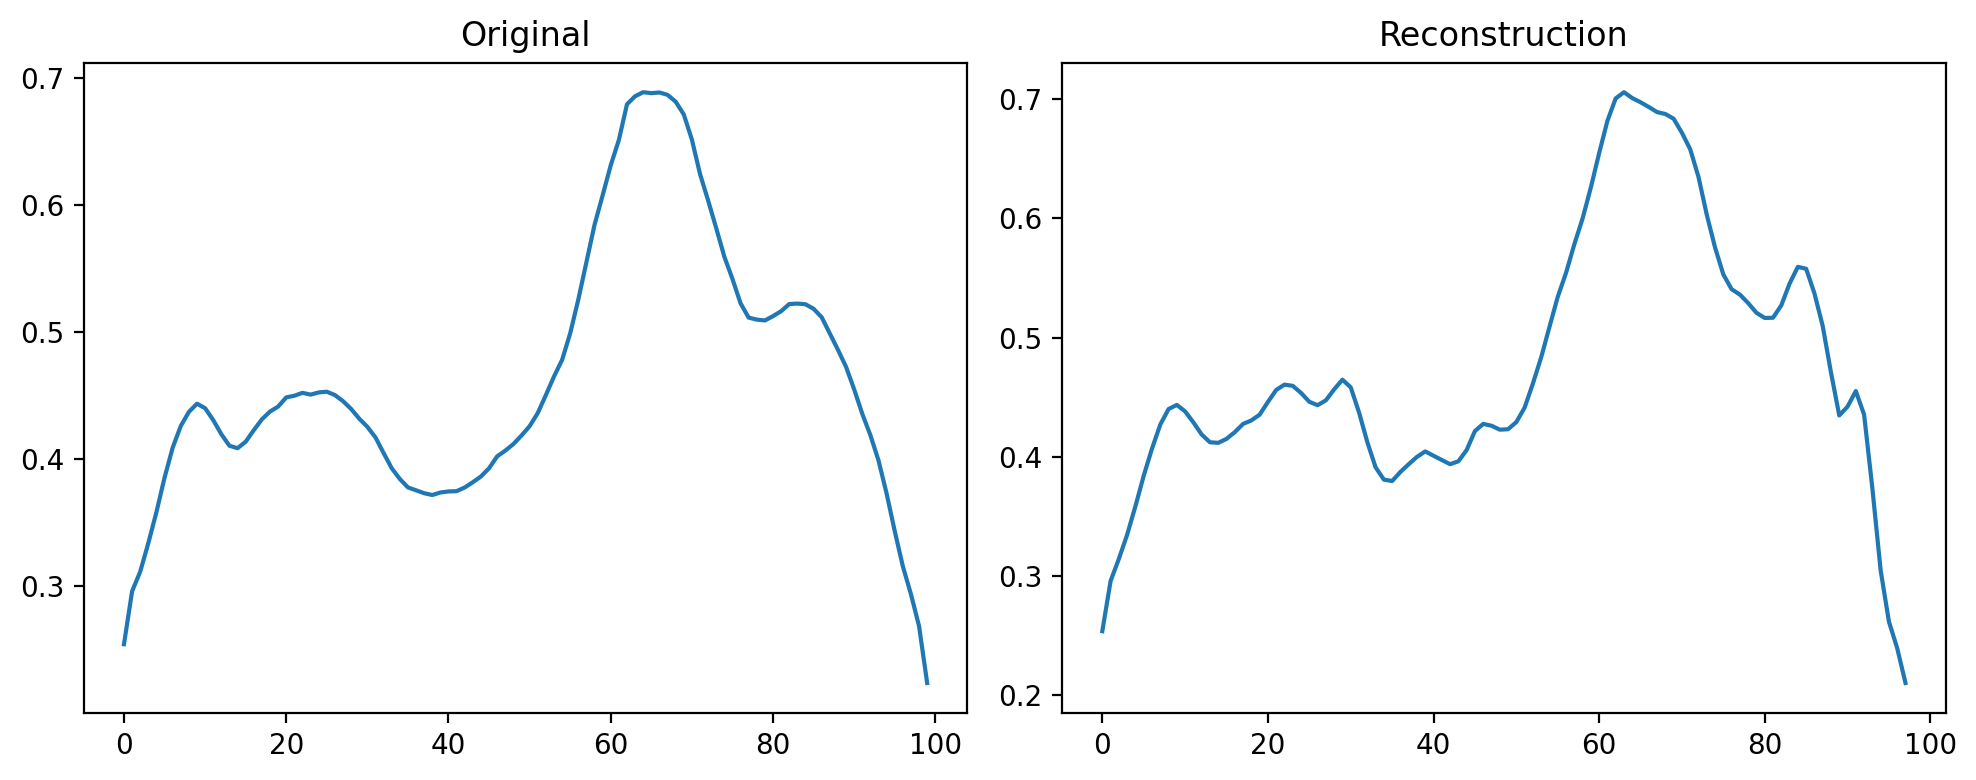

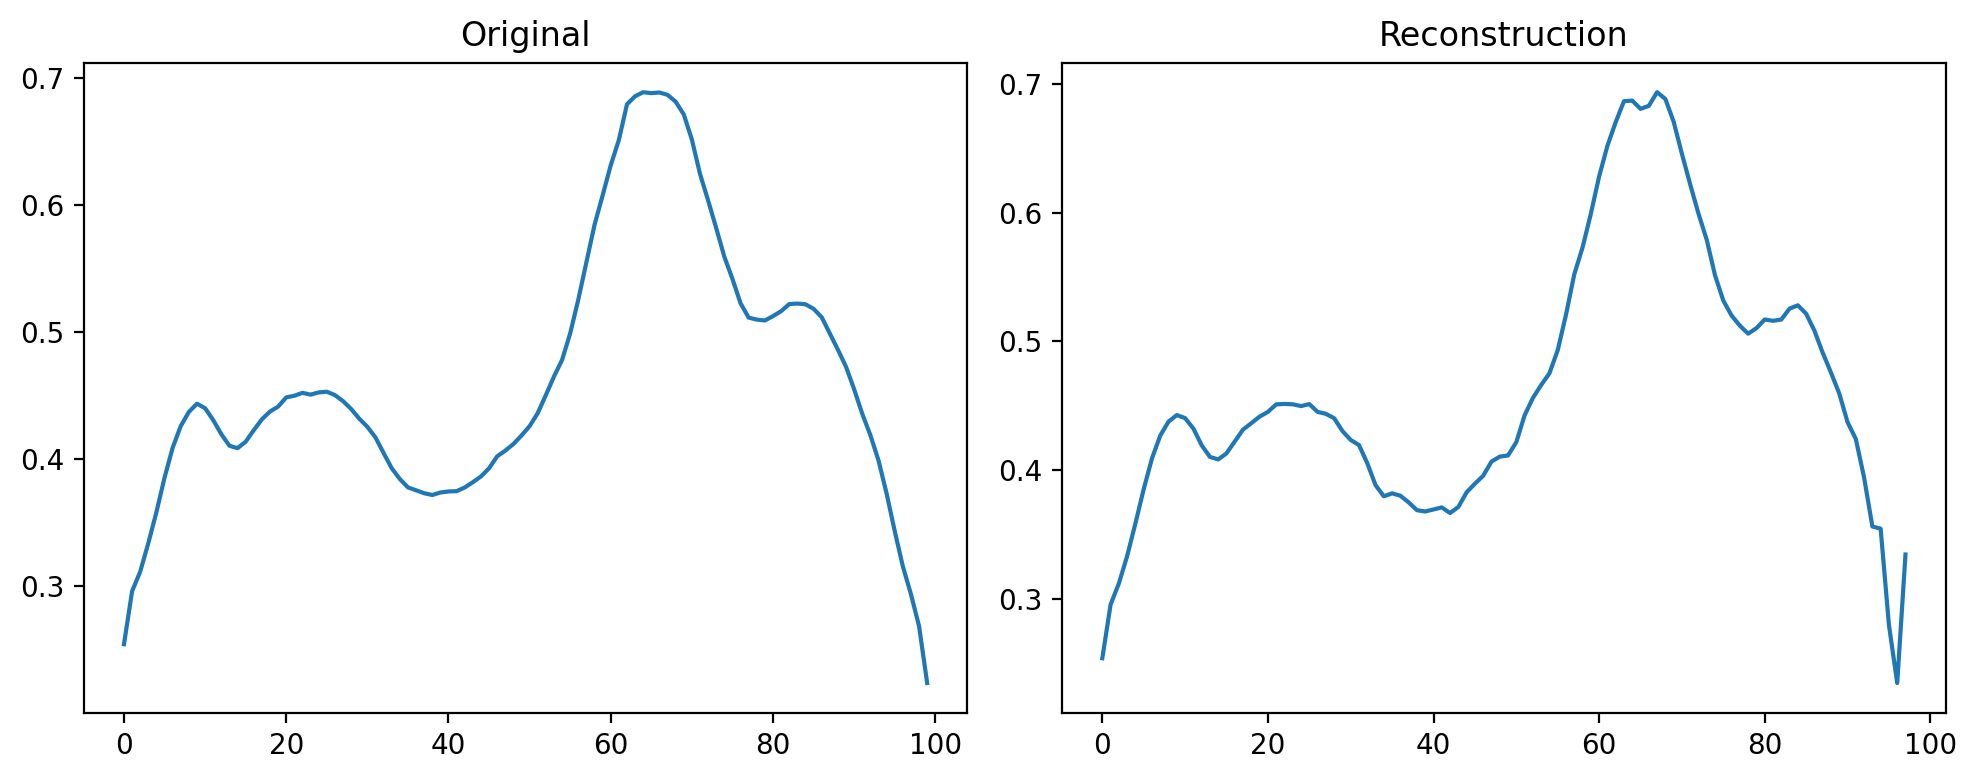

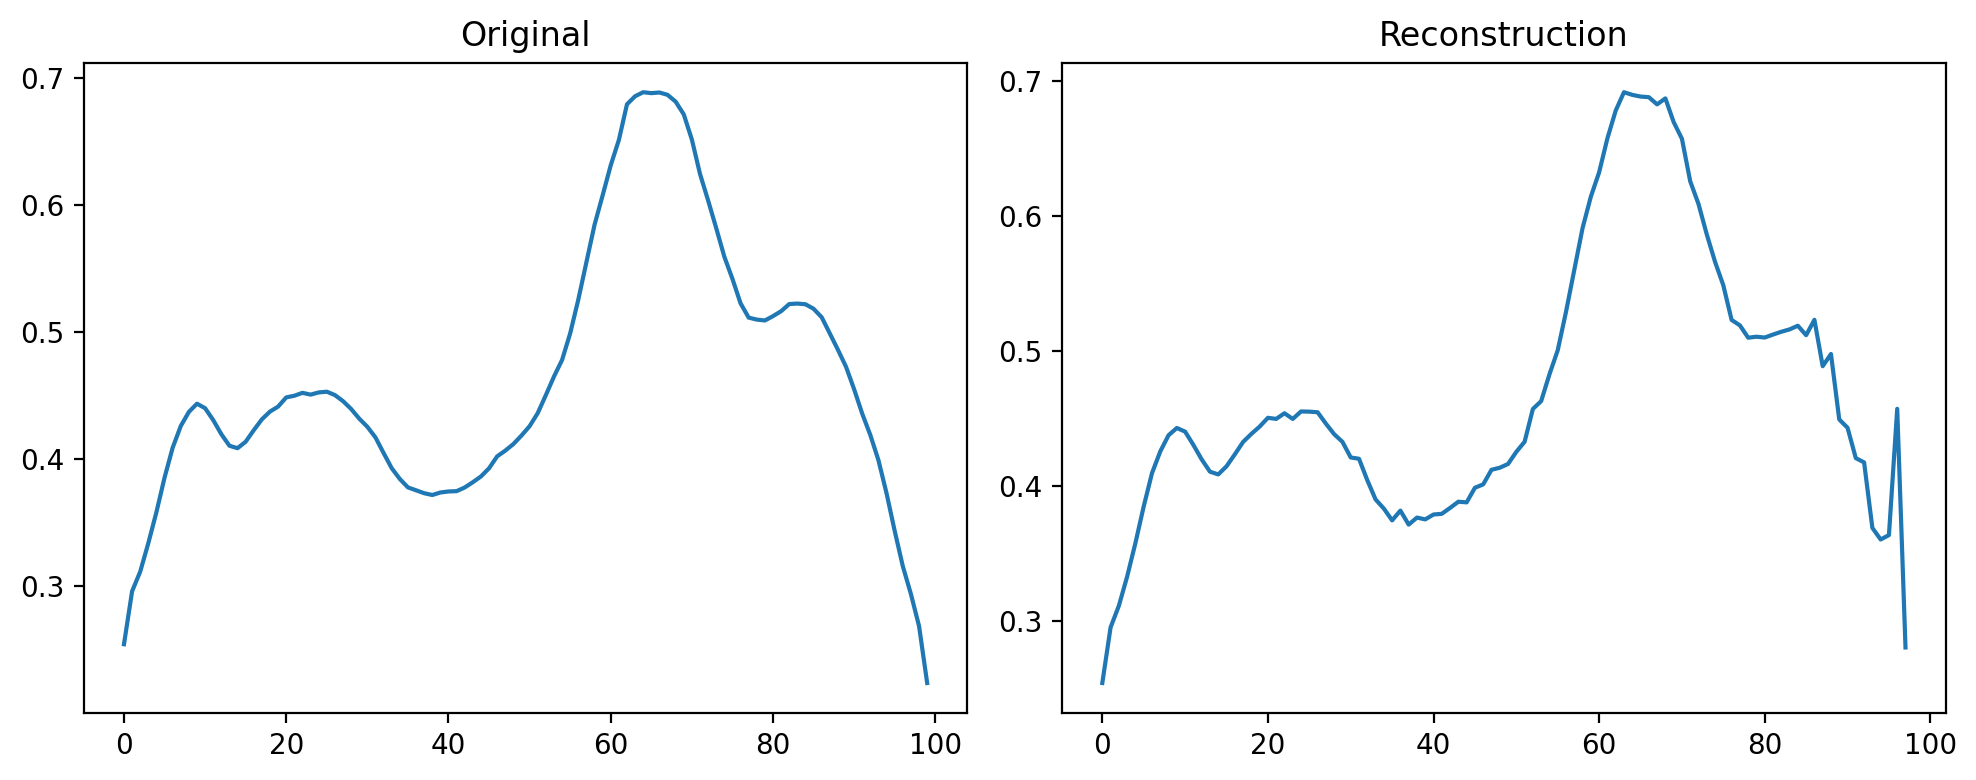

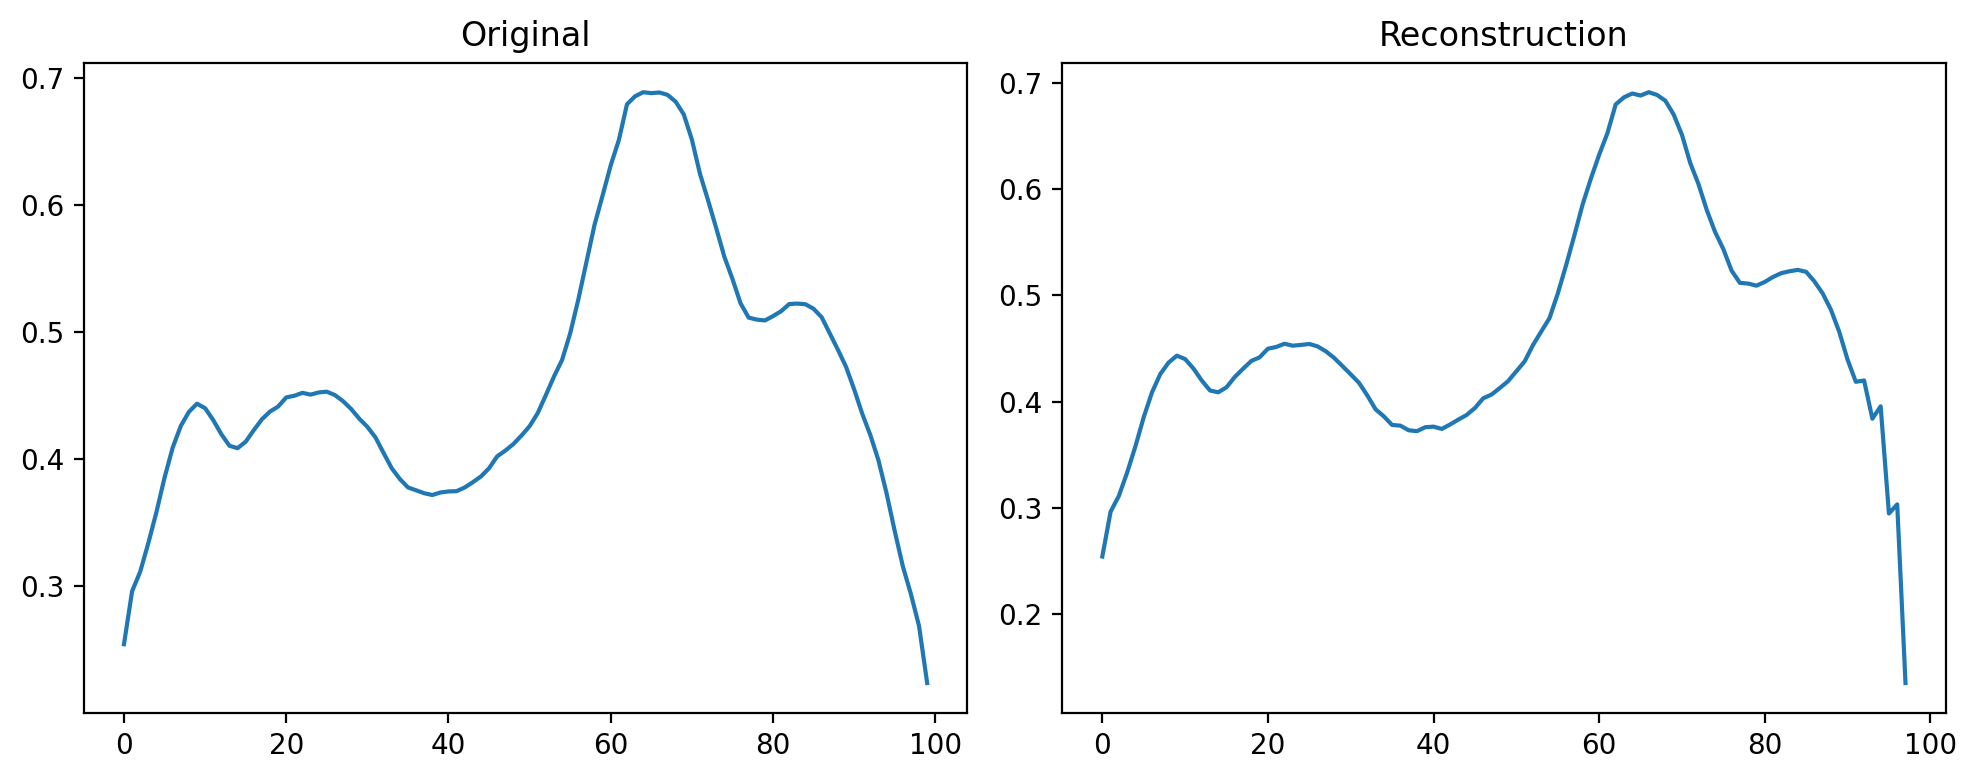

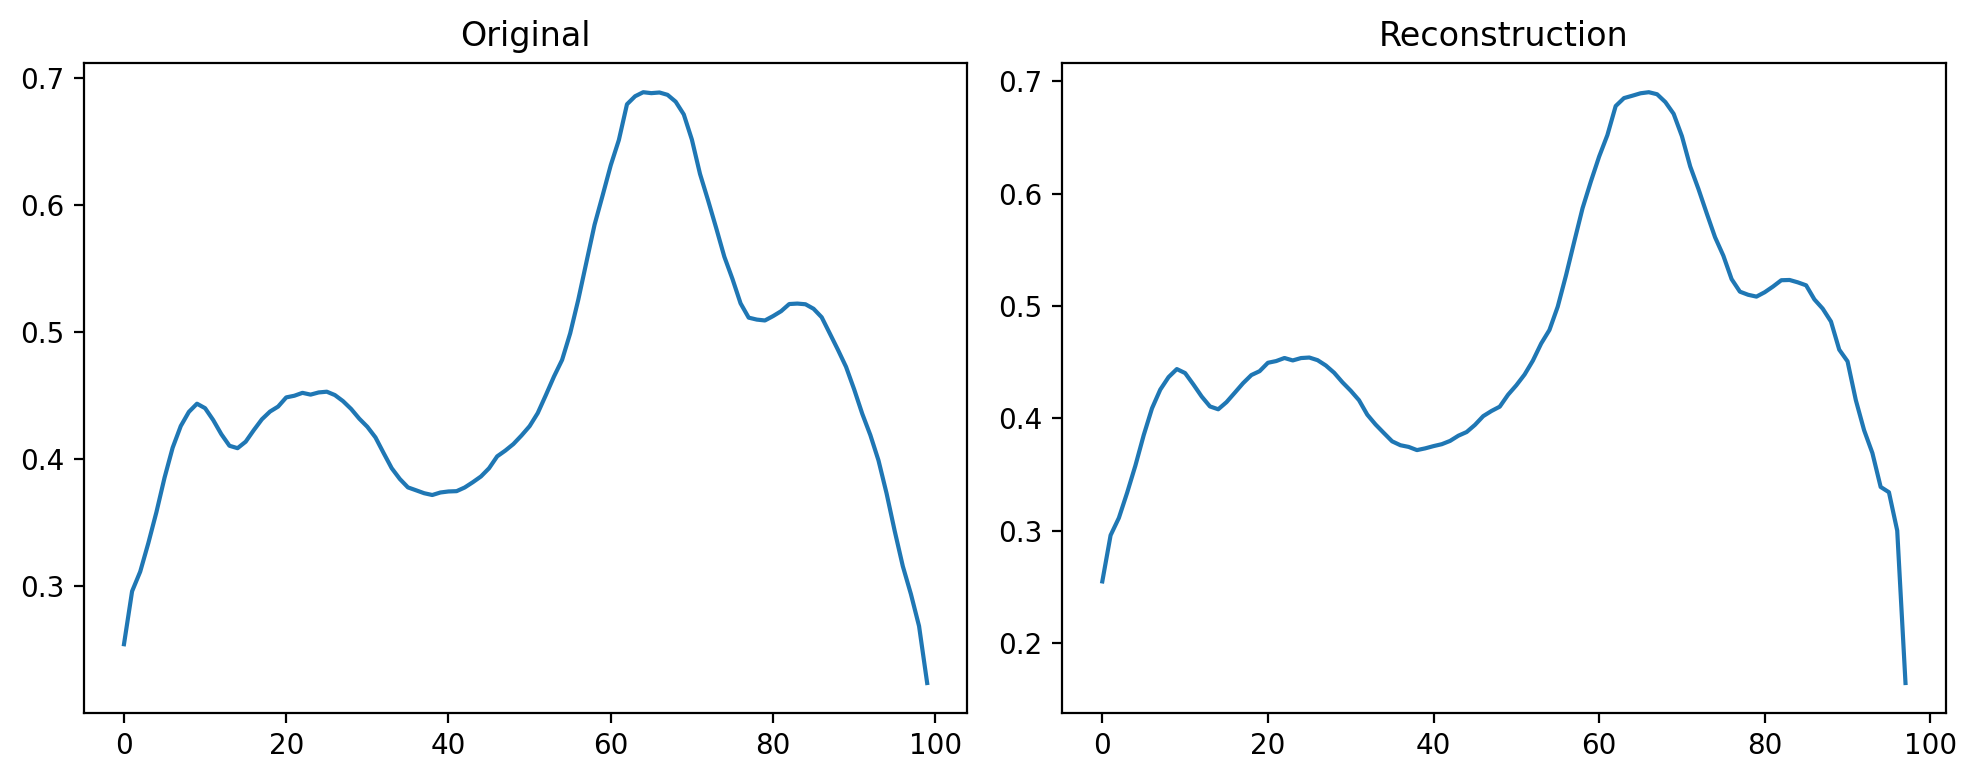

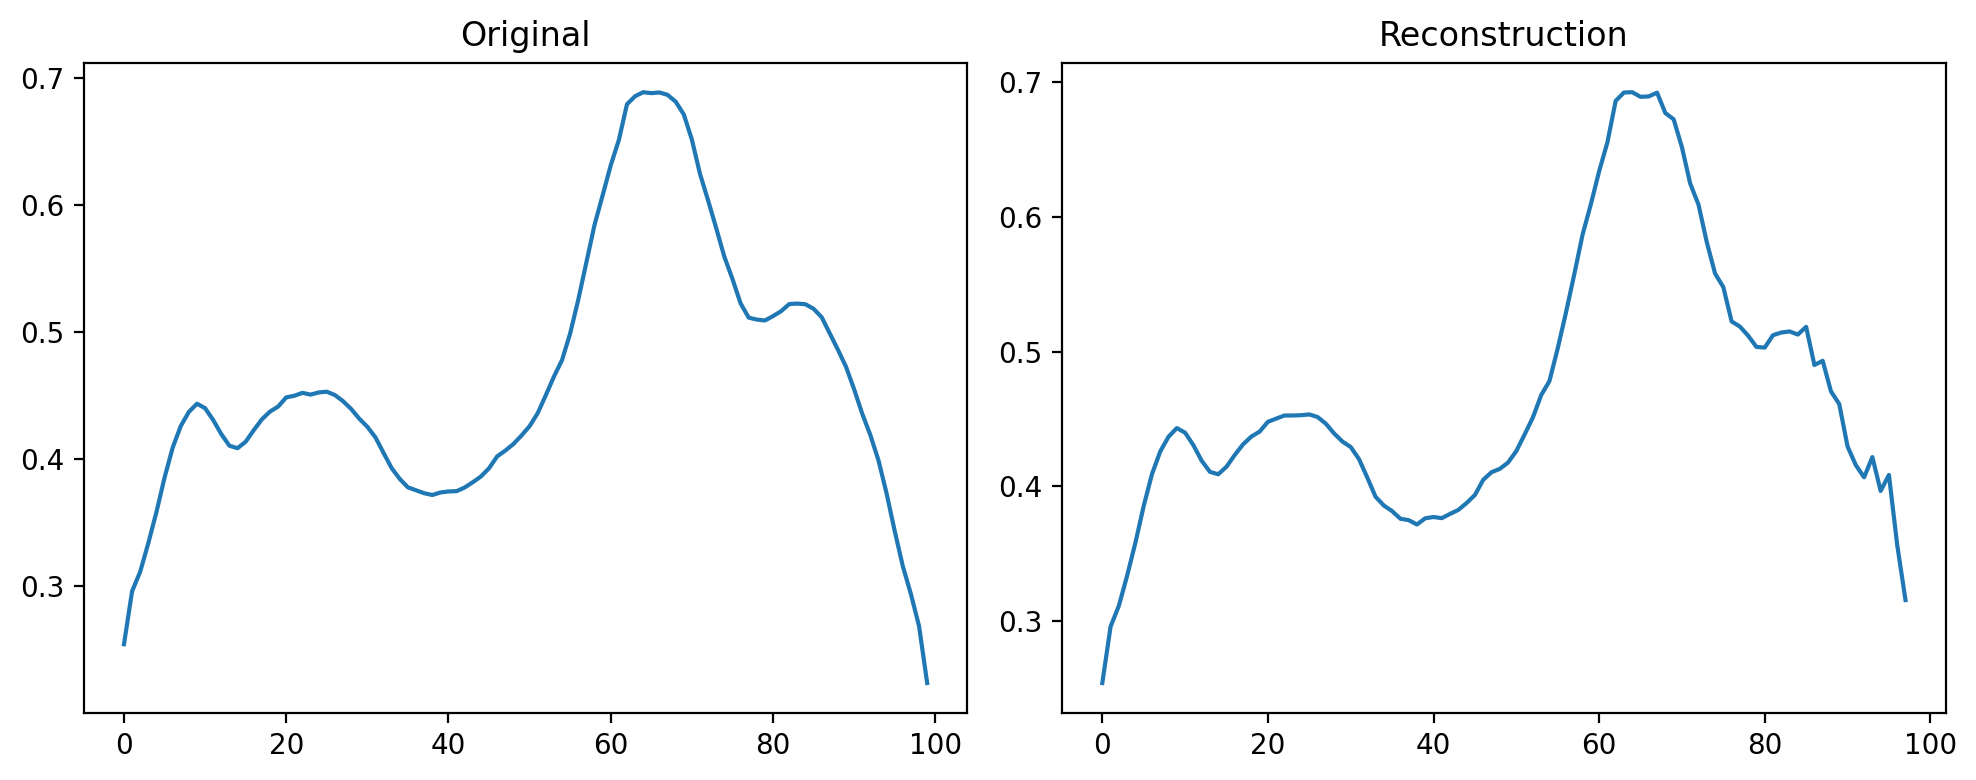

In [19]:
model_with_latent_8 = models[8]

# Visualize a reconstruction
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        for x, _ in data_loader:
            # Take just one sample for visualization
            sample = x[0:1, 0:1, :].to(device)
            reconstruction = model(sample)
            
            # Plot the original and reconstruction
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(sample.cpu().numpy()[0, 0, :])
            plt.title("Original")
            
            plt.subplot(1, 2, 2)
            plt.plot(reconstruction.cpu().numpy()[0, 0, :])
            plt.title("Reconstruction")
            
            plt.tight_layout()
            plt.show()
            break

# Visualize a reconstruction from a model with latent dimension 8
for latent_dim in latent_dims:
    visualize_reconstruction(models[latent_dim], val_loader)

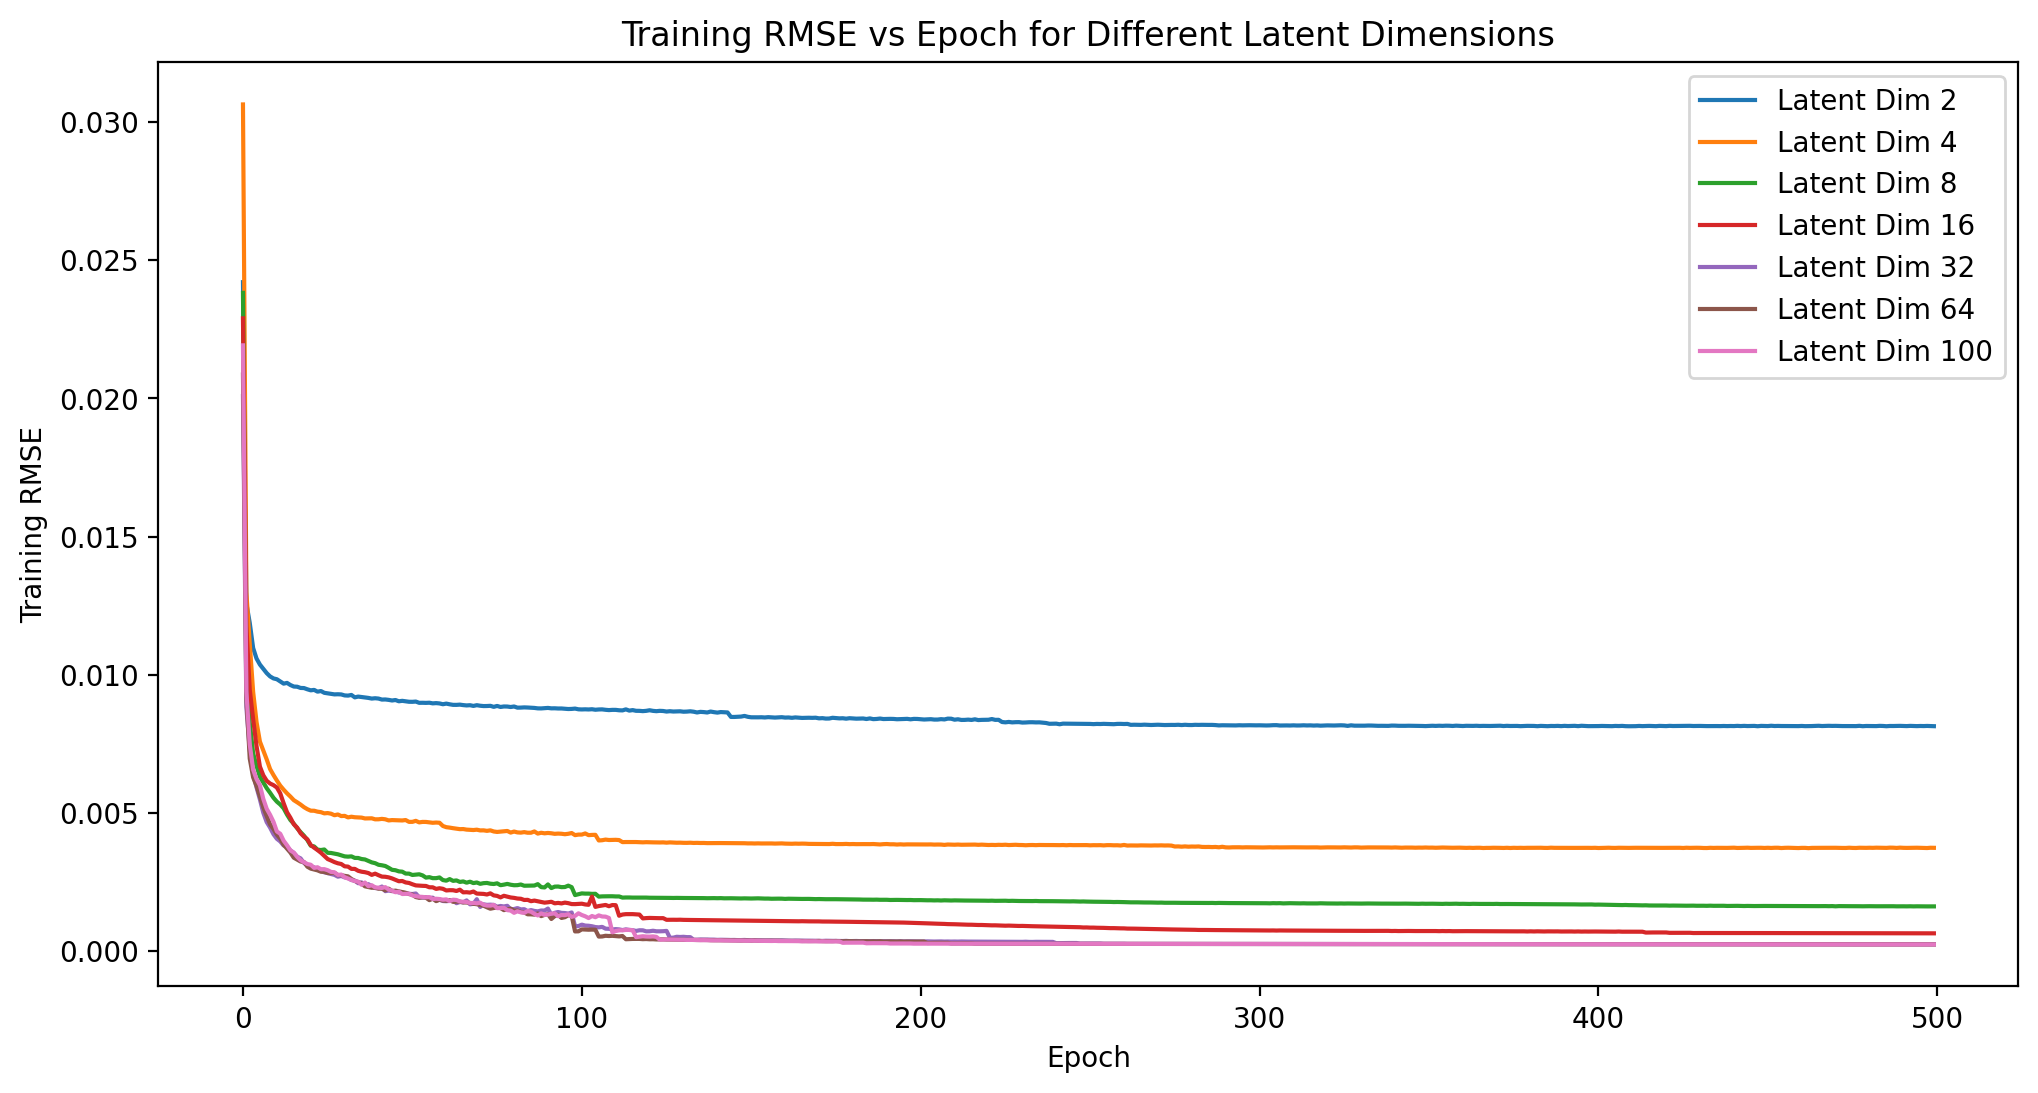

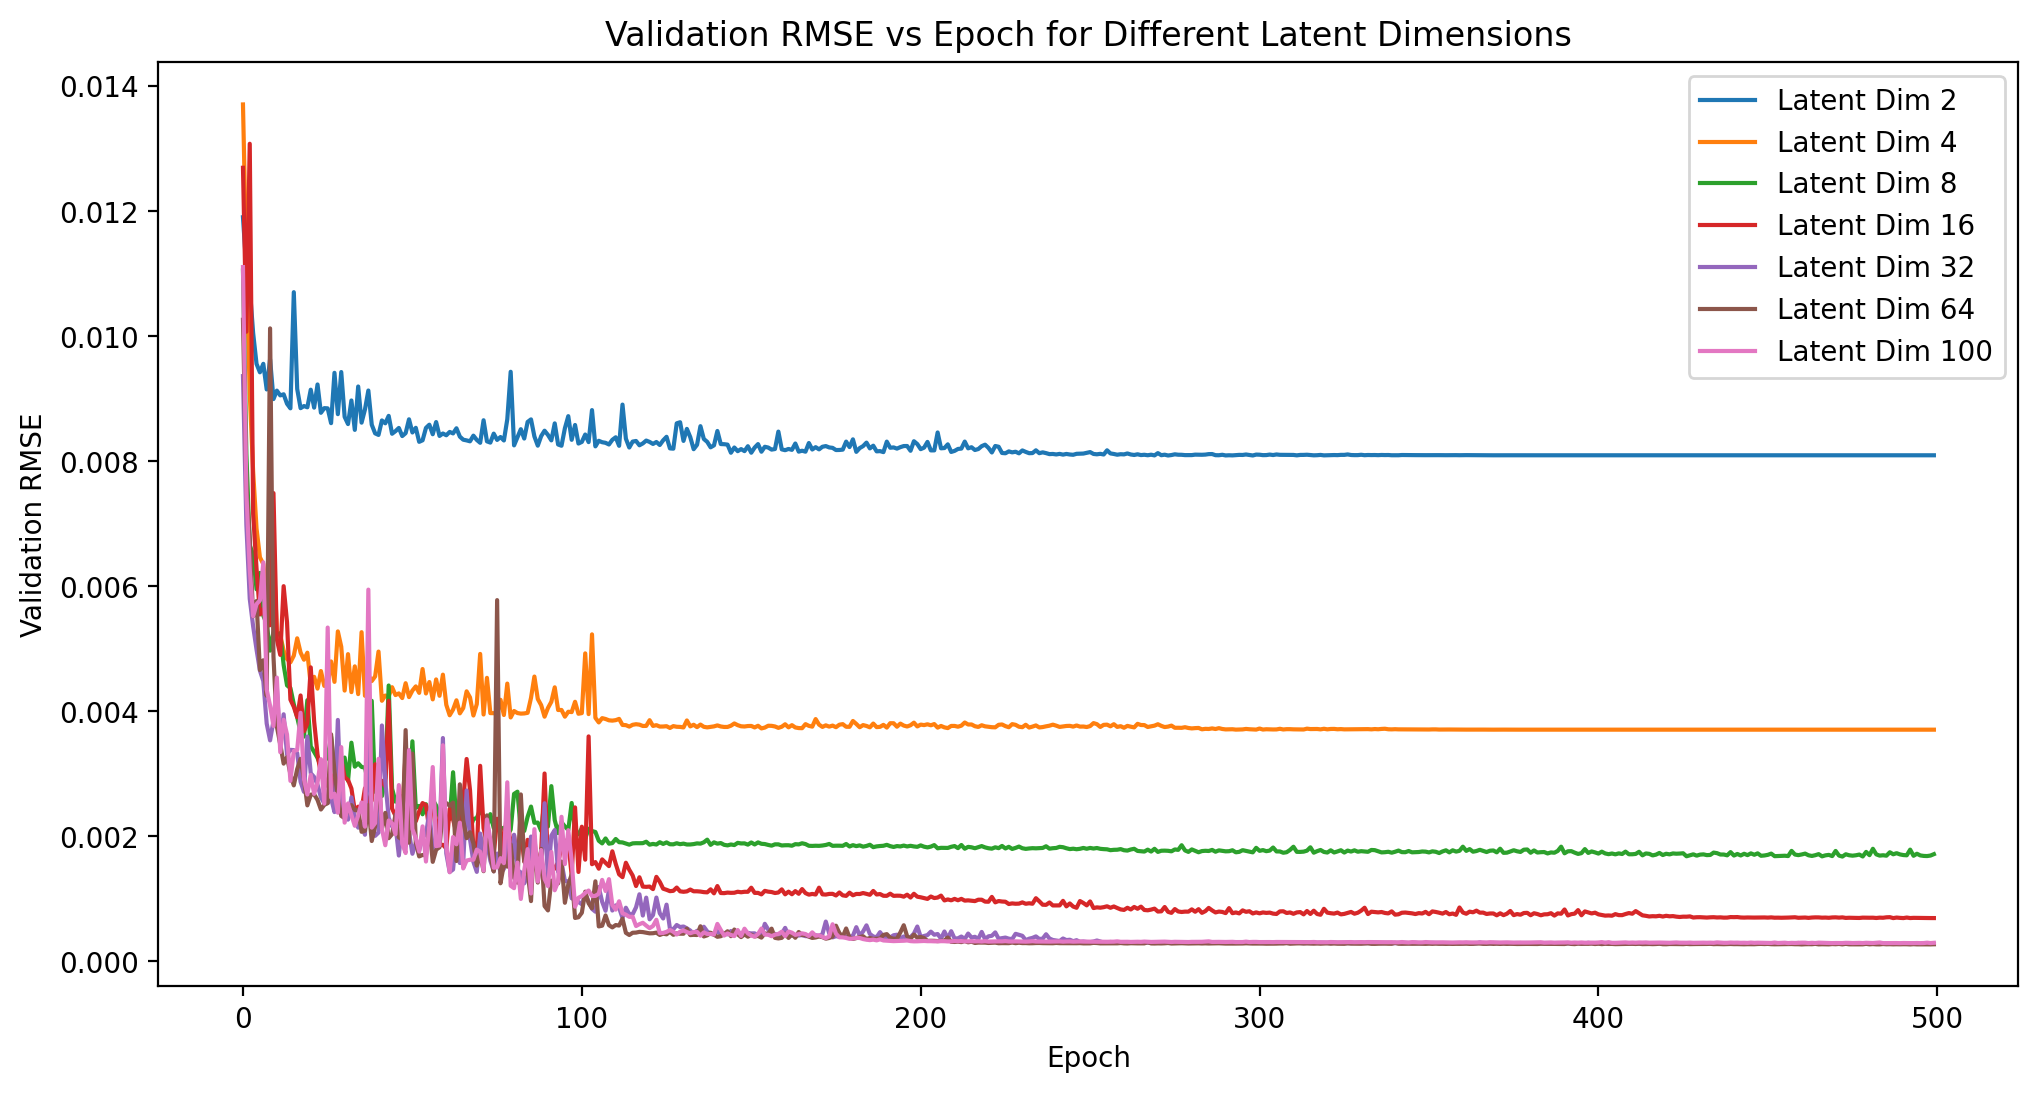

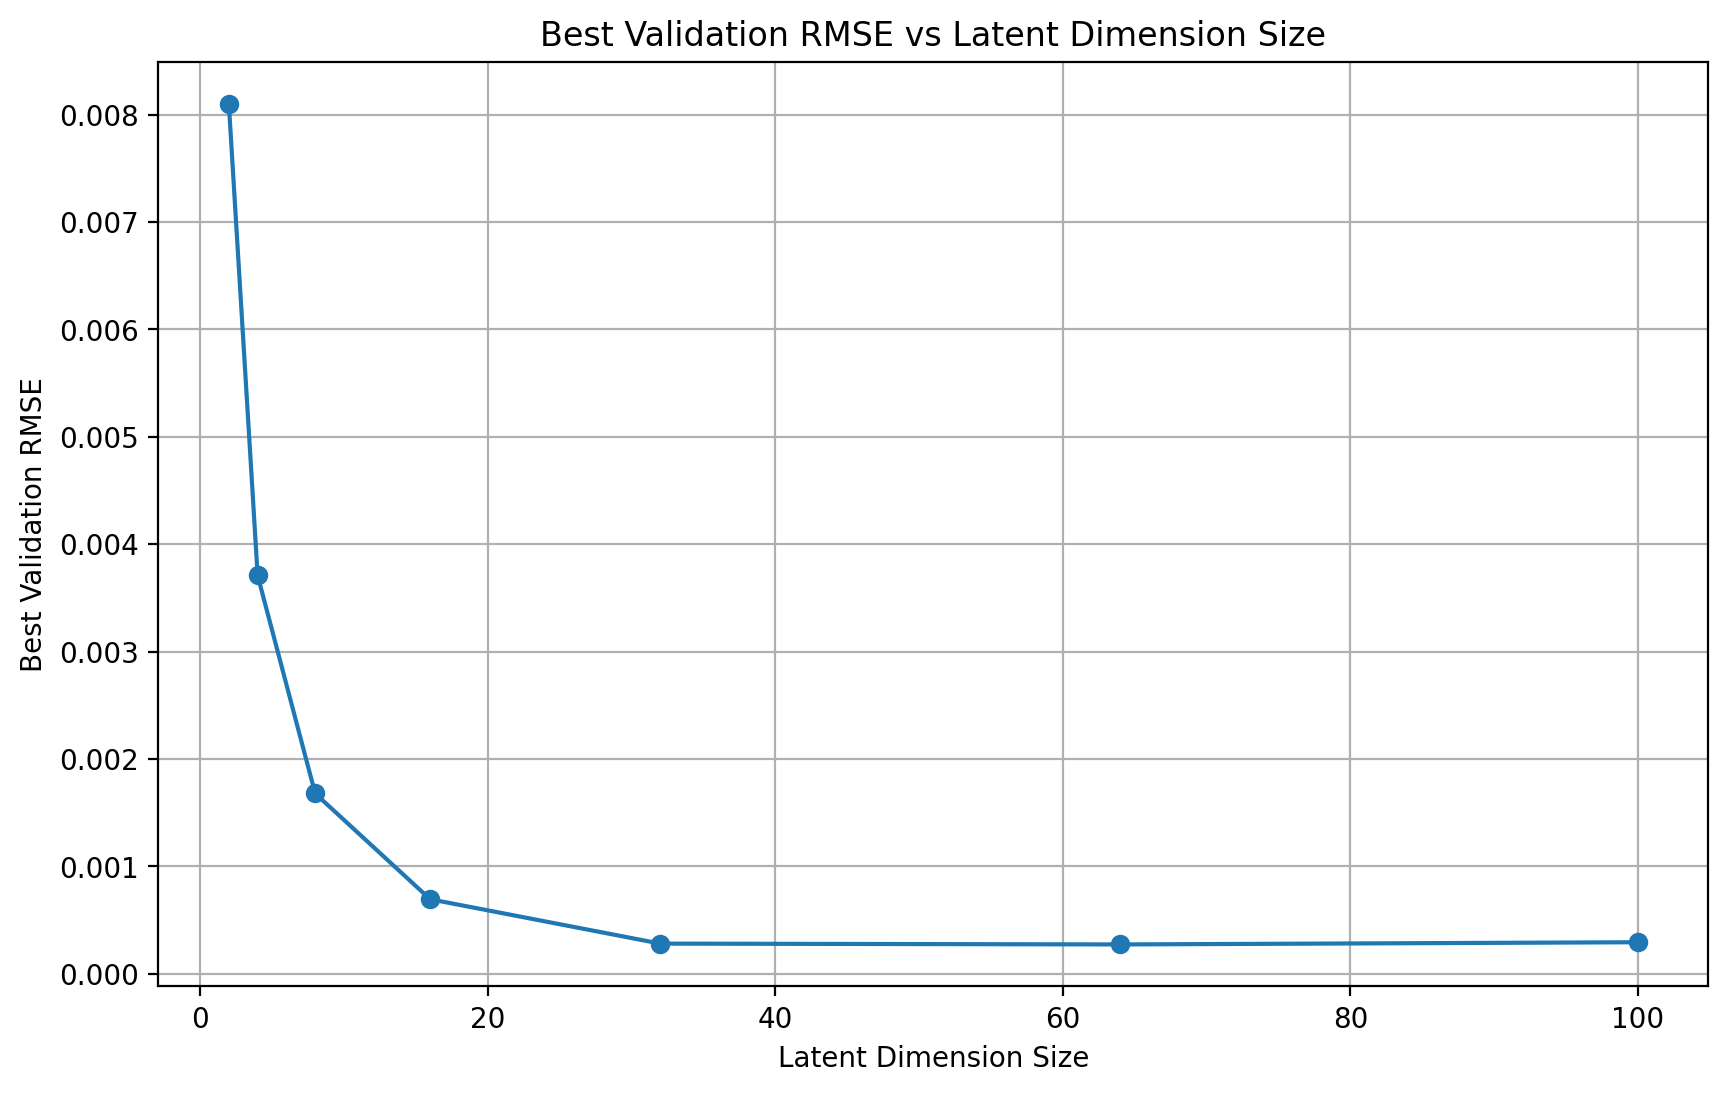

In [15]:
# Plot training RMSE vs epoch for each latent dimension
plt.figure(figsize=(12, 6))
for dim in models.keys():
    plt.plot(results[dim]["train_rmse_per_epoch"], label=f"Latent Dim {dim}")
plt.xlabel("Epoch")
plt.ylabel("Training RMSE")
plt.legend()
plt.title("Training RMSE vs Epoch for Different Latent Dimensions")
plt.show()

# Plot validation RMSE vs epoch for each latent dimension
plt.figure(figsize=(12, 6))
for dim in models.keys():
    plt.plot(results[dim]["val_rmse_per_epoch"], label=f"Latent Dim {dim}")
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.legend()
plt.title("Validation RMSE vs Epoch for Different Latent Dimensions")
plt.show()

# Plot best validation loss for each latent dimension
latent_dims = sorted(list(models.keys()))  # Get sorted list of latent dimensions
best_val_losses = [results[dim]["best_val_loss"] for dim in latent_dims]

plt.figure(figsize=(10, 6))
plt.plot(latent_dims, best_val_losses, 'o-')
plt.xlabel("Latent Dimension Size")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs Latent Dimension Size")
plt.grid(True)
plt.show()

In [21]:
def train_multiple_latent_dimensions(train_data, val_data, epochs=500, lr=0.001, sigma=0.03):
    latent_dims = [2, 4, 8, 16, 32, 64, 100]
    results = []

    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim}")

        # Initialize a new autoencoder for each latent dimension
        model = Conv1DAutoencoder_one_tract_fa(latent_dims=latent_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)

        train_rmse_per_epoch = []
        val_rmse_per_epoch = []
        best_val_loss = float('inf')  # Track the best (lowest) validation RMSE
        best_model_state = None     # Save the best model state

        for epoch in range(epochs):
            # Training
            model.train()
            running_loss = 0
            running_rmse = 0
            items = 0

            for x, _ in train_data:  # x shape: (batch_size, 48, 100)
                batch_size = x.size(0)
                tract_data = x[:, 0:1, :].to(device)  # Shape: (batch_size, 100)

                opt.zero_grad()
                x_hat = model(tract_data)

                loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
                batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                loss.backward()
                opt.step()

                items += tract_data.size(0)
                running_loss += loss.item()
                running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

            scheduler.step(running_loss / items)
            avg_train_rmse = running_rmse / items
            train_rmse_per_epoch.append(avg_train_rmse)

            # Validation
            model.eval()
            val_rmse = 0
            val_items = 0

            with torch.no_grad():
                for x, _ in val_data:
                    tract_data = x[:, 0:1, :].to(device)
                    x_hat = model(tract_data)
                    batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
                    val_items += tract_data.size(0)
                    val_rmse += batch_val_rmse.item() * tract_data.size(0)

            avg_val_rmse = val_rmse / val_items
            val_rmse_per_epoch.append(avg_val_rmse)

            # Check and save the best model state if current validation loss is lower
            if avg_val_rmse < best_val_loss:
                best_val_loss = avg_val_rmse
                best_model_state = model.state_dict()

            print(f"Latent Dim {latent_dim} - Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}")

        results.append({
            "latent_dim": latent_dim,
            "train_rmse_per_epoch": train_rmse_per_epoch,
            "val_rmse_per_epoch": val_rmse_per_epoch,
            "best_val_loss": best_val_loss,
            "best_model_state": best_model_state  # Optional: Save checkpoint for later use
        })

    return results

In [22]:
results = train_multiple_latent_dimensions(all_tracts_train_loader, all_tracts_val_loader)

Training Autoencoder with Latent Dimension: 2
Latent Dim 2 - Epoch 1, Train RMSE: 0.0356, Val RMSE: 0.0318
Latent Dim 2 - Epoch 2, Train RMSE: 0.0221, Val RMSE: 0.0238
Latent Dim 2 - Epoch 3, Train RMSE: 0.0198, Val RMSE: 0.0236
Latent Dim 2 - Epoch 4, Train RMSE: 0.0182, Val RMSE: 0.0196
Latent Dim 2 - Epoch 5, Train RMSE: 0.0171, Val RMSE: 0.0165
Latent Dim 2 - Epoch 6, Train RMSE: 0.0163, Val RMSE: 0.0202
Latent Dim 2 - Epoch 7, Train RMSE: 0.0157, Val RMSE: 0.0187
Latent Dim 2 - Epoch 8, Train RMSE: 0.0153, Val RMSE: 0.0206
Latent Dim 2 - Epoch 9, Train RMSE: 0.0149, Val RMSE: 0.0225
Latent Dim 2 - Epoch 10, Train RMSE: 0.0148, Val RMSE: 0.0198
Latent Dim 2 - Epoch 11, Train RMSE: 0.0145, Val RMSE: 0.0186
Latent Dim 2 - Epoch 12, Train RMSE: 0.0144, Val RMSE: 0.0209
Latent Dim 2 - Epoch 13, Train RMSE: 0.0142, Val RMSE: 0.0167
Latent Dim 2 - Epoch 14, Train RMSE: 0.0141, Val RMSE: 0.0181
Latent Dim 2 - Epoch 15, Train RMSE: 0.0141, Val RMSE: 0.0198
Latent Dim 2 - Epoch 16, Train RM

In [10]:
import matplotlib.pyplot as plt

latent_dims = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

latent_dims = [result["latent_dim"] for result in results]
best_val_losses = [result["best_val_loss"] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(latent_dims, best_val_losses, marker='o')
plt.xlabel("Latent Dimension")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Latent Dimension")
plt.grid()
plt.show()

TypeError: 'int' object is not subscriptable

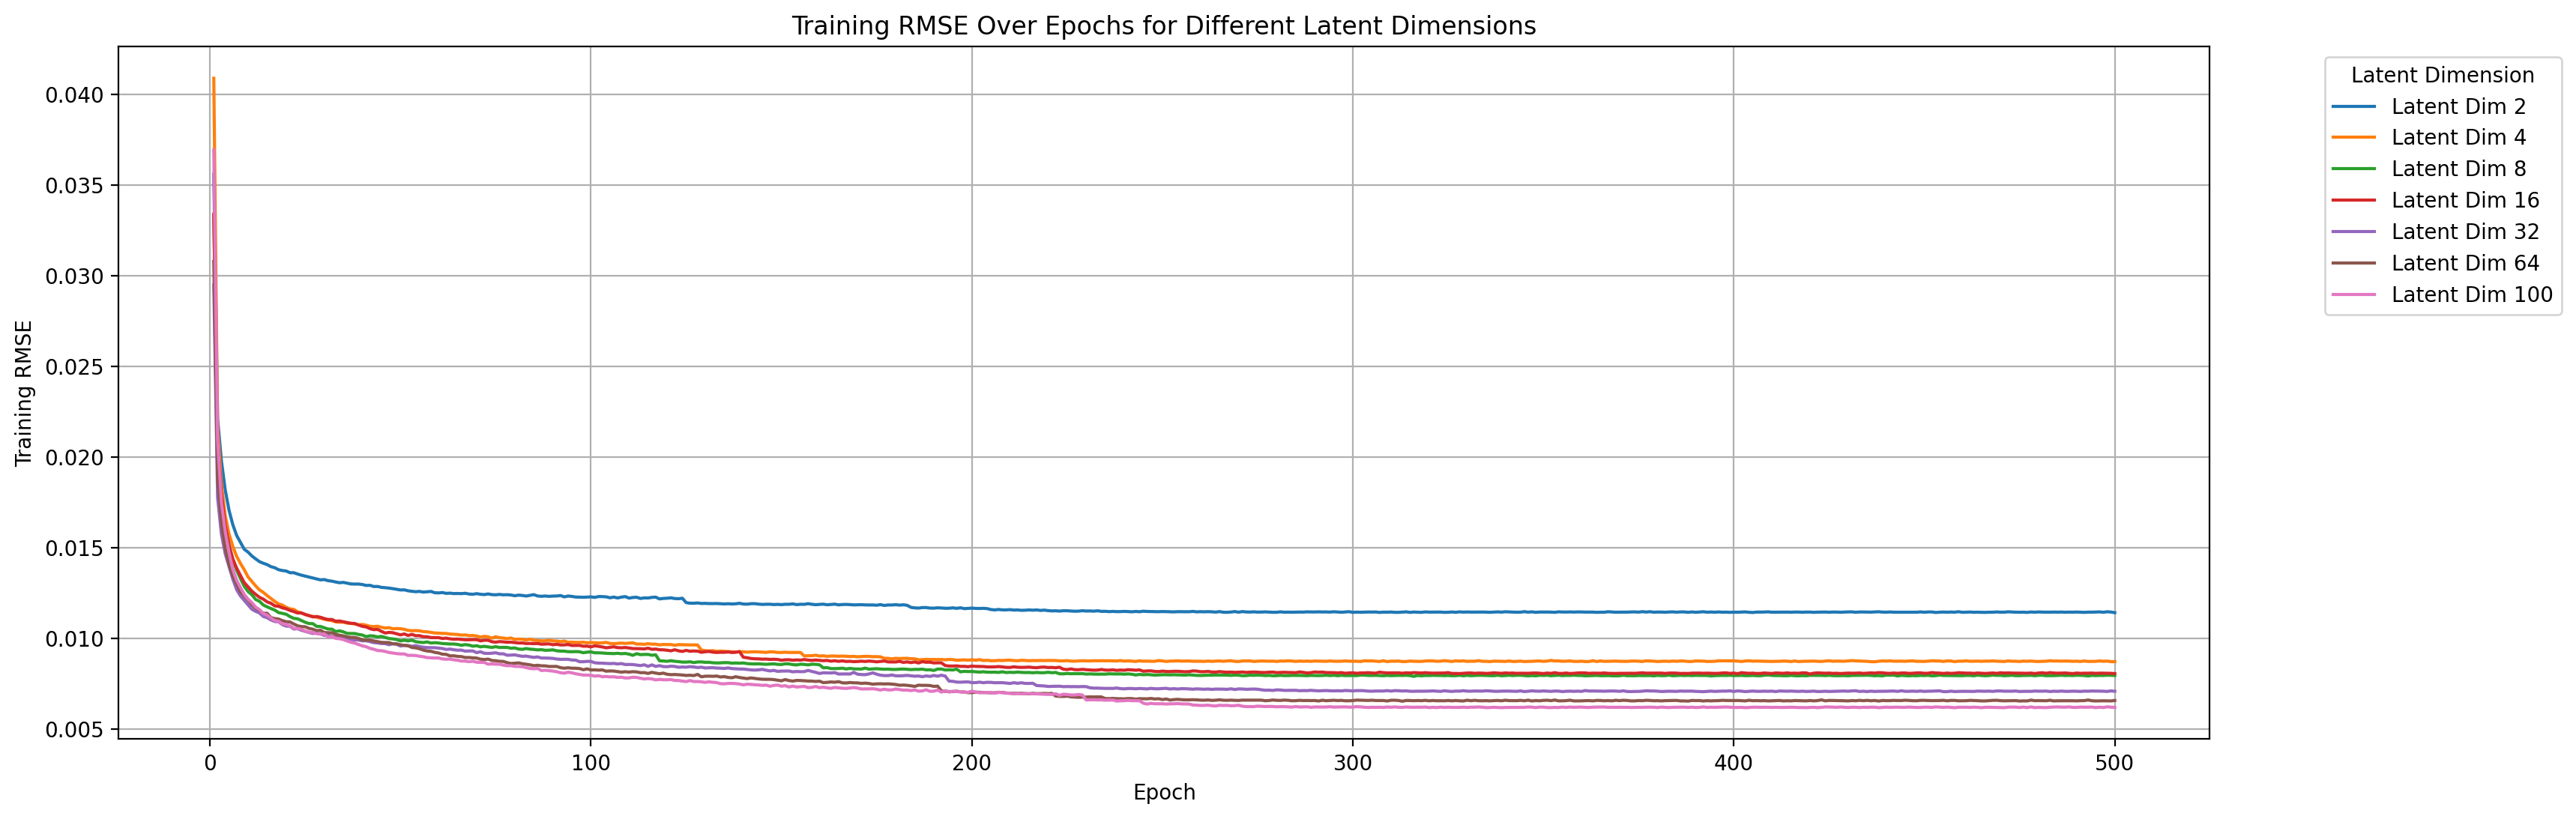

In [25]:
#plot 1, train rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results: 
    plt.plot(
        range(1, len(result["train_rmse_per_epoch"]) + 1),
        result["train_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}",  
    )
plt.xlabel("Epoch")
plt.ylabel("Training RMSE")
plt.title("Training RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()

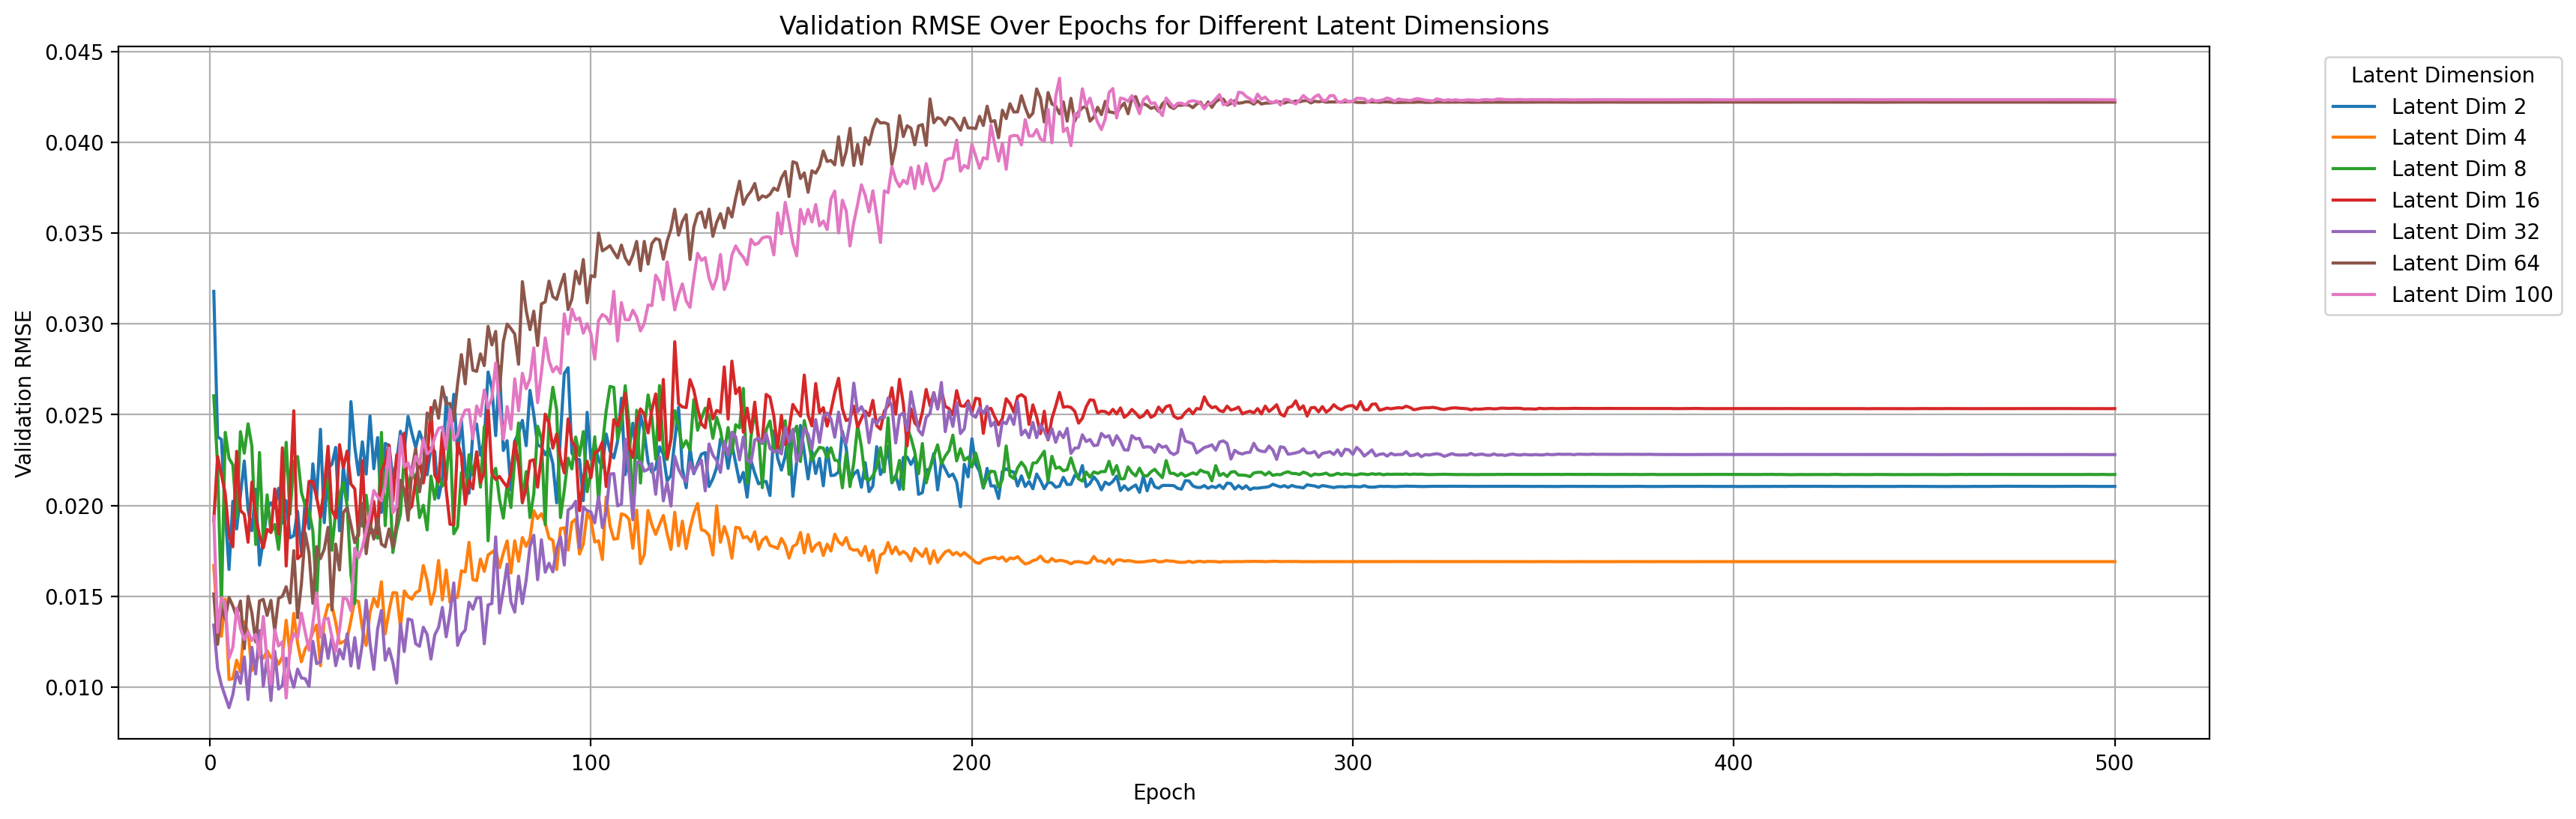

In [26]:
#plot 2, val rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results:  
    plt.plot(
        range(1, len(result["val_rmse_per_epoch"]) + 1),
        result["val_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}", 
    )
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()

RuntimeError: Boolean value of Tensor with more than one value is ambiguous